In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from statsmodels.tsa.seasonal import STL, seasonal_decompose, MSTL
from matplotlib.ticker import FuncFormatter

In [17]:
#read csv
data = pd.read_csv('../data/populationdensity/hourly_taz.csv')
#taz_id to taz_name dict
taz_id_name = {}
for taz_id in data['taz_id'].unique():
    taz_name = data[data['taz_id'] == taz_id]['taz_name'].values[0]
    taz_id_name[taz_id] = taz_name
data

,taz_id,taz_name,one_time,sum_terminals,sum_roaming_terminals,sum_terminals_with_active_data,sum_roaming_terminals_with_active_data,sum_phonecalls,sum_ended_phonecalls,avg_upstream_bandwidth,avg_downstream_bandwidth,min_avg_downstream_bandwidth,min_avg_upstream_bandwidth,max_upstream_bandwidth,max_downstream_bandwidth,sum_sum_terminals_sharing,wkt_taz
0,69,Areeiro (Alto Pina),2021-11-26 09:00:00,61599.0,1131.0,58113.0,1107.0,2896.0,574.0,7524.772105,101178.976512,104.328000,105.621997,39330404.0,135947840.0,0.00,POLYGON ((-9.131441060130475 38.74471703960398...
1,70,Arroios (Estefânia),2021-11-26 09:00:00,145078.0,4477.0,138532.0,4351.0,5149.0,1178.0,7678.938176,53412.218959,2752.320035,14550.430893,63988960.0,405100896.0,12.43,POLYGON ((-9.144729944918017 38.73514419538672...
2,71,Arroios (Arroios | Norte),2021-11-26 09:00:00,31194.0,945.0,29608.0,920.0,1284.0,420.0,5017.655536,58454.086946,943.014966,842.953344,3146271.0,142608816.0,0.00,POLYGON ((-9.136504202275457 38.73689574768296...
3,53,Alvalade (Campo Grande),2021-11-26 09:00:00,51055.0,864.0,48474.0,849.0,1520.0,474.0,8951.088582,70079.739010,2236.359946,17768.382601,33589812.0,96555216.0,0.00,"POLYGON ((-9.15660999782037 38.7593274576093, ..."
4,40,Lumiar (Telheiras | Oeste),2021-11-26 09:00:00,40523.0,255.0,37014.0,252.0,2314.0,382.0,3442.786203,32570.243025,1.238571,0.000000,16425652.0,168218912.0,0.00,"POLYGON ((-9.17712280774748 38.76422000124379,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175218,16,Estrela (Estrela),2021-11-26 09:00:00,199615.0,6739.0,190222.0,6497.0,7990.0,1839.0,10347.174511,75677.619332,573.914546,628.886265,67788656.0,566004672.0,0.00,"POLYGON ((-9.16455004654274 38.71408737534585,..."
175219,12,Ajuda (Ajuda | Norte),2021-11-26 09:00:00,27901.0,487.0,25890.0,481.0,1100.0,342.0,199281.838168,236425.820611,0.000000,0.000000,130461056.0,152884192.0,0.00,POLYGON ((-9.194104152143993 38.72438283212201...
175220,15,Estrela (Lapa),2021-11-26 09:00:00,9932.0,432.0,9298.0,429.0,605.0,154.0,3801.634144,39603.158490,1.328000,0.000000,1539097.0,67348640.0,0.00,POLYGON ((-9.167543700000001 38.70657329999994...
175221,13,Estrela (Ribeirinha - Belém),2021-11-26 09:00:00,6586.0,138.0,6119.0,138.0,410.0,77.0,2781.907062,16101.249632,0.000000,0.000000,11564562.0,18501752.0,0.00,POLYGON ((-9.161911000000002 38.70242249999994...


In [18]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
resids = {}
#for each taz_id
for taz_id in data['taz_id'].unique():
    #get the data for that taz_id
    taz_data = data[data['taz_id'] == taz_id]
    taz_data = taz_data.drop(columns=['taz_name'])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=['one_time', "taz_id", "wkt_taz"])
    taz_data.set_index('datetime', inplace=True) 
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq('H')
        if np.all(time_serie == 0):
            continue
        res = MSTL(np.squeeze(time_serie), periods=[24,24*7]).fit()
        resids[str(taz_id)+"_"+data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
        noise_strength = var_resid/var_observed

        seasonal_individial_strengths = {}
        for period in res.seasonal:
            seasonal_individial_strengths["F_"+str(period)] = max(0, 1 - (var_resid/np.var(res.seasonal[period] + res.resid)))
        seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal.sum(axis=1) + res.resid)))


        stats_df = {"id": taz_id, "Feature": data_feature,
                    "F_T": round(trend_strength, 3),
                    "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
            
        #add individual seasonal strengths to stats_df, rounded with 3 decimals
        for period in seasonal_individial_strengths:
            stats_df[period] = round(seasonal_individial_strengths[period], 3)
                
        stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)
        
stats_table

,id,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168
0,69,sum_terminals,0.448,0.426,0.391,0.260,0.278
1,70,sum_terminals,0.325,0.822,0.164,0.749,0.620
2,71,sum_terminals,0.373,0.564,0.346,0.404,0.380
3,53,sum_terminals,0.336,0.862,0.129,0.811,0.652
4,40,sum_terminals,0.595,0.454,0.307,0.325,0.262
...,...,...,...,...,...,...,...
98,89,sum_terminals,0.158,0.893,0.105,0.885,0.447
99,95,sum_terminals,0.045,0.727,0.273,0.561,0.587
100,101,sum_terminals,0.158,0.744,0.247,0.634,0.550
101,39,sum_terminals,0.327,0.697,0.259,0.532,0.528


In [19]:
stats_table = stats_table.sort_values(by=['F_R'], ascending=False)
#save the table
stats_table.to_csv('../results/populationdensity/hourly_taz_seasonal_strengths.csv', index=False)
#get the name from the taz id
stats_table['Name'] = stats_table['id'].apply(lambda x: taz_id_name[x])
stats_table


,id,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168,Name
5,37,sum_terminals,0.059,0.404,0.574,0.267,0.236,São Domingos de Benfica (Estrada Luz | Oeste)
34,80,sum_terminals,0.232,0.430,0.485,0.301,0.244,Beato (Picheleira)
45,6,sum_terminals,0.105,0.517,0.456,0.439,0.221,Alcântara (Ribeirinha - Belém)
7,41,sum_terminals,0.057,0.554,0.434,0.414,0.351,Lumiar (Telheiras | Este)
66,77,sum_terminals,0.352,0.445,0.425,0.319,0.252,Penha de França (Penha França)
...,...,...,...,...,...,...,...,...
84,100,sum_terminals,0.371,0.878,0.113,0.845,0.632,Parque das Nações (Estação Oriente)
65,74,sum_terminals,0.672,0.862,0.108,0.837,0.522,Santa Maria Maior (Baixa)
98,89,sum_terminals,0.158,0.893,0.105,0.885,0.447,Lumiar (Aeroporto)
69,29,sum_terminals,0.863,0.732,0.102,0.649,0.458,São Domingos de Benfica (Sete Rios | Norte)


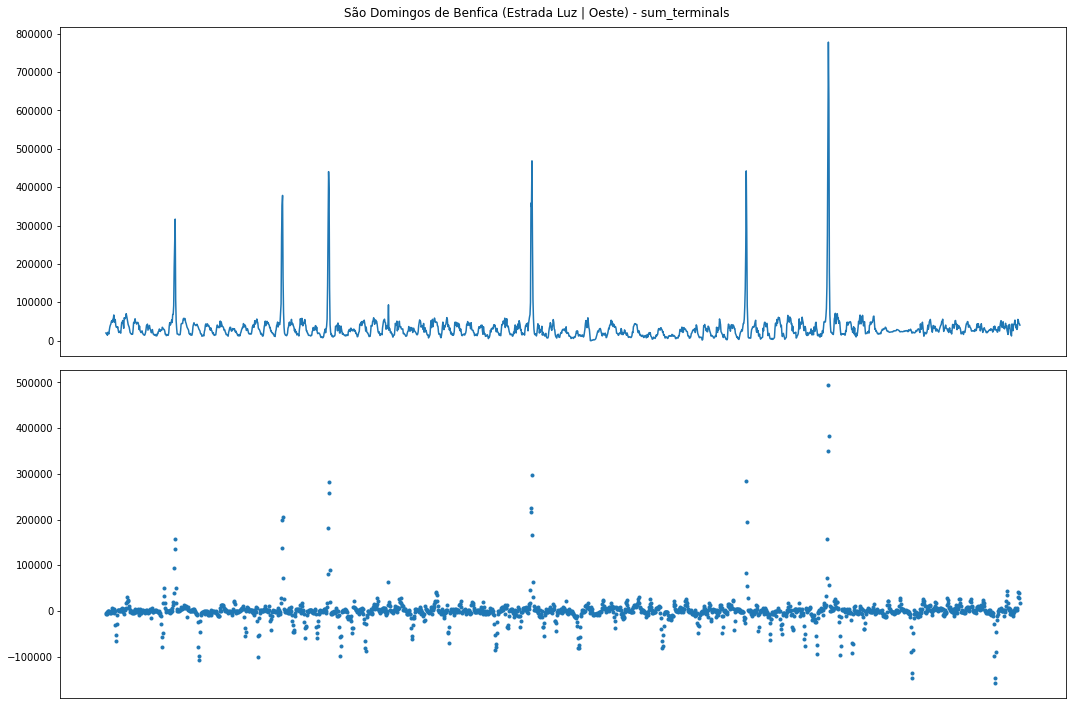

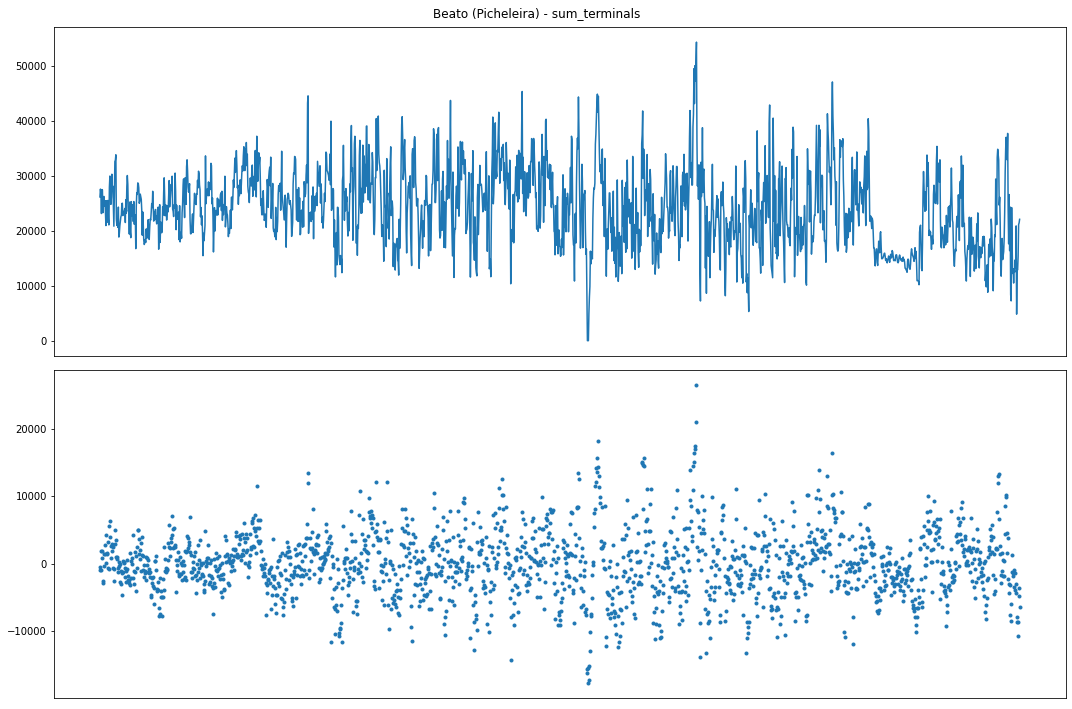

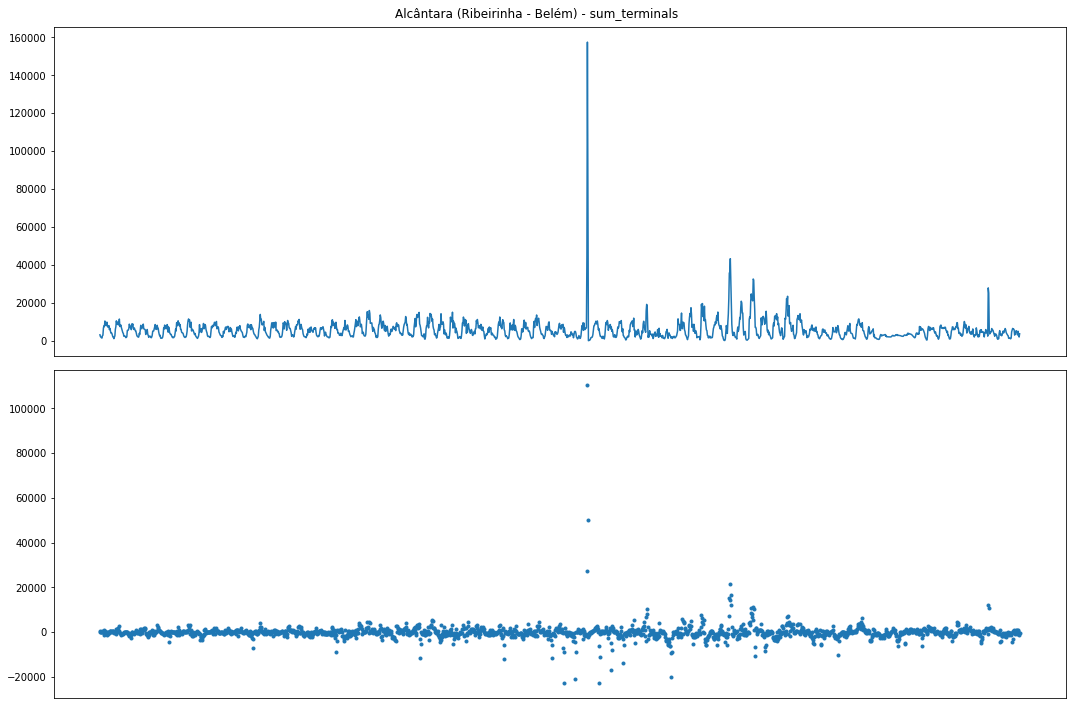

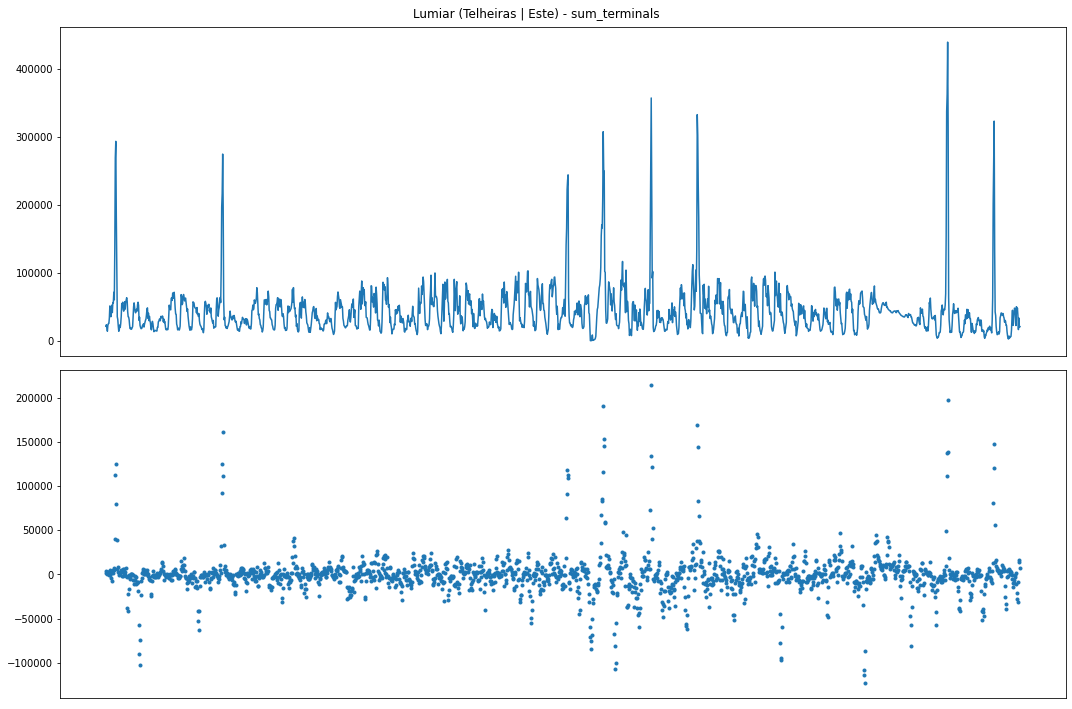

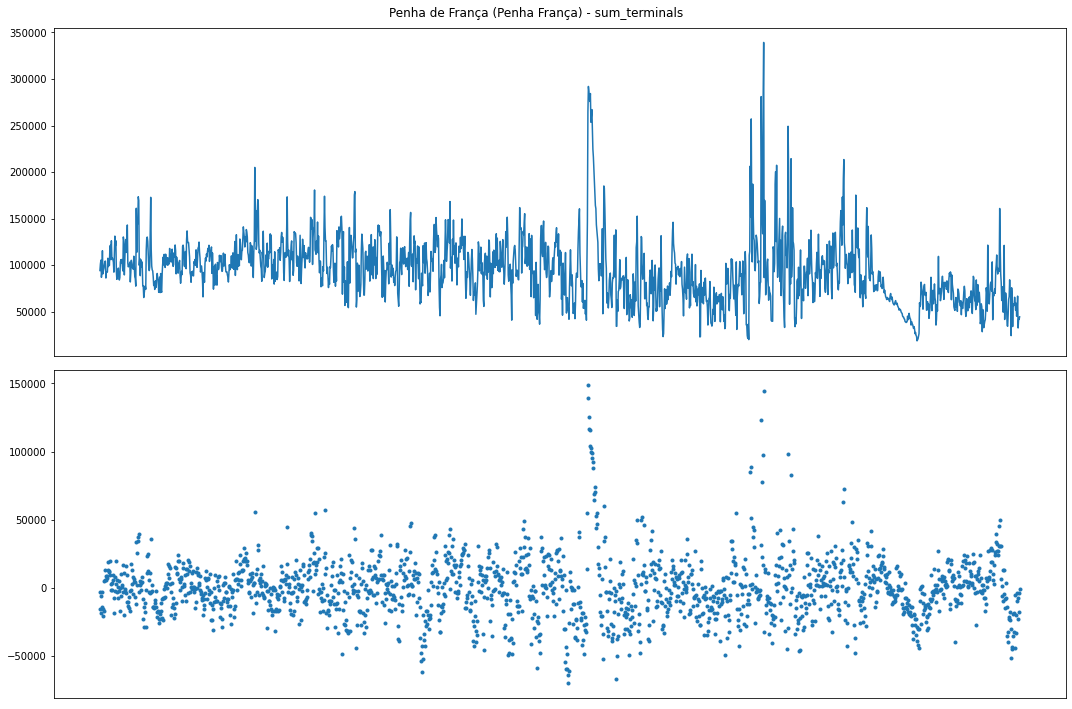

In [20]:
#plot the data and residuals of top 5 taz_ids
top_taz_ids = stats_table['id'].head(5).values
#create dict with taz_id and resids
top_resids = {}
for taz_id in top_taz_ids:
    for data_feature in features:
        top_resids[str(taz_id)+"_"+data_feature] = resids[str(taz_id)+"_"+data_feature]

for taz_id in top_taz_ids:
    for data_feature in features:
        time_serie = data[data['taz_id'] == taz_id][[data_feature, 'one_time']]
        time_serie.sort_values(by='one_time', inplace=True)
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))
        ax[0].plot(time_serie['one_time'], time_serie[data_feature])
        ax[1].plot(time_serie['one_time'], resids[str(taz_id)+"_"+data_feature], label='Residuals', marker='.', linestyle='None')
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        #set title of figure
        fig.suptitle(f"{taz_id_name[taz_id]} - {data_feature}")
        plt.tight_layout()
        plt.show()

In [21]:
#motif discovery
import stumpy

# discover motifs
normalize = True
subsequence_lengths = [6,12,24]
min_neighbors = 1

In [22]:
for m in subsequence_lengths:
    for resid in top_resids:
        X = top_resids[resid]
        out = stumpy.stump(X, m, normalize=normalize)
        mp = out[:, 0]
        np.save('../results/populationdensity/motifs/motifs_normalized={}_m={}_{}.npy'.format(normalize,m,resid), mp)


ValueError: too many values to unpack (expected 2)

In [ ]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))


        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # dist_media_elemento = SQRT((dist^2)/n_length)
        #max_delta = max_allowed_dist        # dist_max do motif = dist_max de um elemento (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [ ]:
k = None
min_neighbors = 1
cutoffs = np.inf
max_matches = 99999
max_distance = np.inf
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    for resid in top_resids:
        X = top_resids[resid]
        mp = np.load('../results/populationdensity/motifs/motifs_normalized={}_m={}_{}.npy'.format(normalize,m,resid))
        motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.motifs(X, mp, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, normalize=normalize)
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))  
        table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
        print("Sig ", np.sum(table["p-value"] < 0.01))
        mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs), index=False)


